Author: Yhony Mamani Arce

### Exercise 7.1

Write a Monte Carlo program to determine the temperature dependence of the energy and magnetization of a two-dimensional Ising model on square lattice. Choose a lattice size appropriate to the power of the computer you are using. Useful illustrative result can be obtained using lattice of size as small as 6 $\times$ 6. Discuss

i) the initial conditions used

ii) the boundary conditions

iii) the number of  steps required to achieve thermodynamic equilibrium

iv) error bars for the results at each temperature

v) the effect of the finite system size 

**First:** we introduce the libraries that we are going to use

- [numpy](https://numpy.org/doc/stable/user/quickstart.html): is a Python library and it is used for working with arrays.
- [matplotlib](https://matplotlib.org/stable/tutorials/index.html): is a low level graph plotting library in python that serves as a visualization utility.
- [numba](https://numba.pydata.org/numba-doc/latest/user/5minguide.html): is a just-in-time compiler for Python that works best on code that uses NumPy arrays and functions, and loops.
- [tqdm](https://www.geeksforgeeks.org/python-how-to-make-a-terminal-progress-bar-using-tqdm/): Using tqdm we just need to add our code between tqdm() after importing the library in our code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

from numba import jit, prange
from tqdm.auto import tqdm

We define the initial state as a function called **"init_state(N)"**. It is the initial condition that we will use. **The initial conditions used in this simulation are random spins, where each spin is randomly chosen to be up or down.**

In [2]:
@jit(nopython=True)
def init_state(N):
  return np.random.choice(np.array([-1,1]),size=(N,N))

To illustrate we choose N = 6, which is the dimension of the array 6 x 6

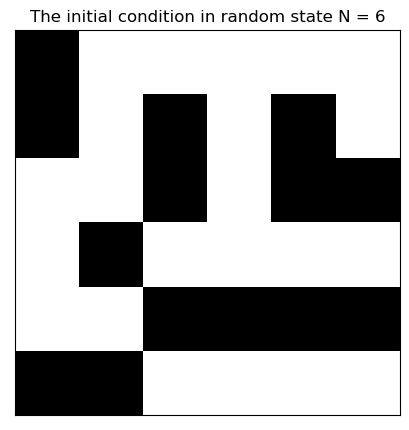

In [3]:
N = 6
try_state = init_state(N)
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(try_state, cmap = plt.cm.gist_gray) 
ax.set_xticks([])
ax.set_yticks([])
plt.title('The initial condition in random state N = ' + str(N))
plt.show()

The Hamiltonian H of the system is:
$$H(\{s\})=-\frac{J}{2}\sum_{<ij>}s_{i,j}(s_{i+1,j}+s_{i-1,j}+s_{i,j+1}+s_{i,j-1})$$
where $s_{i,j}=\pm 1$, J is the interaction strength of spins. Divide the Hamiltonian by 2, since we count each site contribution to each of the 2 neighbours.

**We consider periodic boundary conditions in both directions: $s_{i+L,j}=s_{i,j}$, $s_{i,j+L}=s_{i,j}$**, where L is the dimension of the lattice (L=N).

With these considerations we are going to codify the energy. To do that we define a function as **"energy(state)"**

In [4]:
@jit(nopython=True)
def energy(state):
    
  N = state.shape[0]
  energy = 0
  
  # Loop over all sites
  for i in prange(N):
    for j in prange(N):

      # get nearest neighbours states
      nn = state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N]
      # compute site energy
      energy -=  state[i,j] * nn
 
  return energy / 2 

Here we implement **Monte Carlo simulation**. 

- We go down in energy with probability 1. 
- We go up in energy with probability $e^{-\beta (E_{f} - E_{i})}$. 

Where $E_i$ and $E_f$ are the energies of the initial and final state respectively.

In a spin system, we attempt to flip a spin, check the energy difference $\Delta E = E_f-E_i$. 

- If $\Delta E \leq 0$, accept the move. 
- If $\Delta E \geq 0$, accept with $w = e^{-\beta \Delta E}$. (Generate random number between 0 and 1, compare to $ e^{-\beta \Delta E}$).

For more details see [Statistical Mechanics of Phase Thansitions by Yeomans, pag. 96-97](https://academic.oup.com/book/54829?login=false)

So we defined the function "monte_carlo_step(state, beta)". This function have two variables the state and beta (we consider $\beta = 1/T$ for simplicity).

In [5]:
@jit(nopython=True)
def monte_carlo_step(state, beta):
    
  N = state.shape[0]

  for n in prange(N**2):

      # choose a spin site with uniform probability
      i, j = np.random.randint(0, N, size=2)

      # get sum of nearest neighbour values in the lattice
      nn = state[(i-1)%N, j] + state[(i+1)%N, j] + \
        state[i, (j-1)%N] + state[i, (j+1)%N] # the modulo % operation takes care of the boundaries condition
      
      # get delta energy
      delta = 2 * state[i,j] * nn

      # Metropolis
      if delta < 0 or np.random.random() < np.exp(- beta * delta):
        state[i,j] = -1. * state[i,j]
        
  return state

Let's see how the "monte_carlo_step(state, beta)" function works. Let's choose beta as 1/1 and with the initial state "init_state(N)" (script 2).

**First, second and third run**

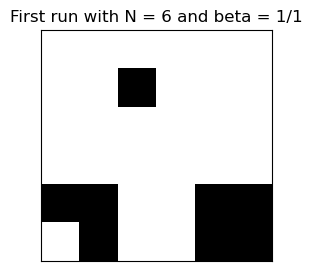

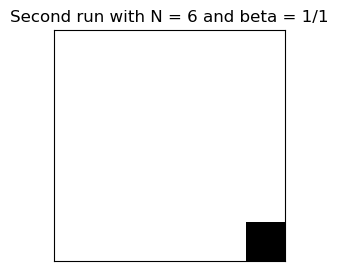

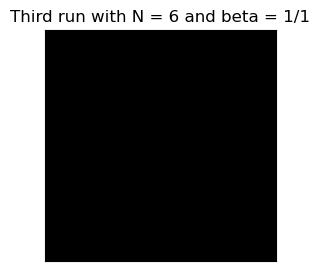

In [6]:
try_state_f = monte_carlo_step(try_state,1/1)
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(try_state_f, cmap = plt.cm.gist_gray) 
ax.set_xticks([])
ax.set_yticks([])
plt.title('First run with N = ' + str(N) + ' and beta = 1/1')
plt.show()

try_state_f = monte_carlo_step(try_state,1/1)
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(try_state_f, cmap = plt.cm.gist_gray) 
ax.set_xticks([])
ax.set_yticks([])
plt.title('Second run with N = ' + str(N) + ' and beta = 1/1')
plt.show()

try_state_f = monte_carlo_step(try_state,1/1)
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(try_state_f, cmap = plt.cm.gist_gray) 
ax.set_xticks([])
ax.set_yticks([])
plt.title('Third run with N = ' + str(N) + ' and beta = 1/1')
plt.show()

....

We can run until we find the thermodynamic equilibrium for some beta, however, it would be manually. 

So for that we are going to create the **"Ising"** function whose parameters are:

   - N: number of sites per dimension
   - beta: 1/T for simplicity
   - eq_steps: initial steps for the equilibration phase
   - steps: effective steps of the simulation
   - order: generate a ordered configuration with uniform magnetization
   - annealing: using simulating annealing during equilibration
   - cluster: to use the [Wolff algorithm](https://en.wikipedia.org/wiki/Wolff_algorithm)
   - verbose: is a general programming term for produce lots of logging outputs

and output:
   - E_mean: Mean energy 
   - M_mean: Mean magnetization
   - E_var: Energy error
   - M_var: Magnetization error
   - E_eq: Energy on equilibration
   - M_eq: Magnetisation on equilibration
   - E: Energy on simulation
   - M Magnetisation on simulation

In [7]:
def Ising(N, beta, eq_steps = int(1e4), steps = int(1e6), order = False, annealing = False, cluster = False, verbose=True):
    
    if verbose:
        print('ISING MODEL')
        print('N:', N, ', beta:', beta, ', cluster:', cluster, ', annealing:', annealing , '\n')

        print('Start equilibration')

  # Initial state
    if order:
        curr_state = np.ones((N,N))
    else:
        curr_state = init_state(N)

    E_eq = np.zeros(eq_steps)
    M_eq = np.zeros(eq_steps)
  
    if annealing:
        ### Equilibration with simulated annealing
        betas = np.zeros(eq_steps)
        N_annealing = eq_steps-eq_steps//10
        betas[:N_annealing] = np.linspace(0.1, beta, num=N_annealing, endpoint=True)
        betas[N_annealing:] = beta
    else:
    ### Equilibration
        betas = np.zeros(eq_steps) + beta
      
  # Loop over time steps
    if verbose:
        for i in tqdm(range(eq_steps)):
            #keep trace of energy and magnetization
            E_eq[i] = energy(curr_state)
            M_eq[i] = np.sum(curr_state)
            #update the state
            if cluster:
                curr_state = wolff(curr_state, betas[i])         
            else:
                curr_state = monte_carlo_step(curr_state, betas[i])

        print('End equilibration \n')
    
    else:
        for i in range(eq_steps):
            #keep trace of energy and magnetisation
            E_eq[i] = energy(curr_state)
            M_eq[i] = np.sum(curr_state)
            #update the state
            if cluster:
                curr_state = wolff(curr_state, betas[i])         
            else:
                curr_state = monte_carlo_step(curr_state, betas[i])
        
  ### Simulation
    if verbose:  
        print('Start simulation.')

  # Define arrays for storing state observables
    E = np.zeros(steps)
    M = np.zeros(steps)
  
    if verbose:
        for i in tqdm(range(steps)):
            #keep trace of energy and magnetization
            E[i] = energy(curr_state)
            M[i] = np.sum(curr_state)
            # Evolve state
            if cluster:
                curr_state = wolff(curr_state, beta)
            else:
                curr_state = monte_carlo_step(curr_state, beta)
        print('End simulation.')
    
    else:
        for i in range(steps):
          #keep trace of energy and magnetisation
            E[i] = energy(curr_state)
            M[i] = np.sum(curr_state)
          # Evolve state
            if cluster:
                curr_state = wolff(curr_state, beta)
            else:
                curr_state = monte_carlo_step(curr_state, beta)

    ### Compute observables
    E_mean, M_mean = np.mean(E), np.mean(M)
    E_var, M_var = np.std(E), np.std(M)

  ### Return results
    return (E_mean, M_mean,
            E_var, M_var,
            E_eq, M_eq, E, M) 

Now we are going to see **how many steps are required to enter equilibrium when $N = 6$** and we are also going to choose beta = 0.25, 1, 2.5. So:

ISING MODEL
N: 6 , beta: 0.25 , cluster: False , annealing: False 

Start equilibration


  0%|          | 0/20 [00:00<?, ?it/s]

End equilibration 

Start simulation.


  0%|          | 0/100 [00:00<?, ?it/s]

End simulation.
ISING MODEL
N: 6 , beta: 1.0 , cluster: False , annealing: False 

Start equilibration


  0%|          | 0/20 [00:00<?, ?it/s]

End equilibration 

Start simulation.


  0%|          | 0/100 [00:00<?, ?it/s]

End simulation.
ISING MODEL
N: 6 , beta: 2.5 , cluster: False , annealing: False 

Start equilibration


  0%|          | 0/20 [00:00<?, ?it/s]

End equilibration 

Start simulation.


  0%|          | 0/100 [00:00<?, ?it/s]

End simulation.


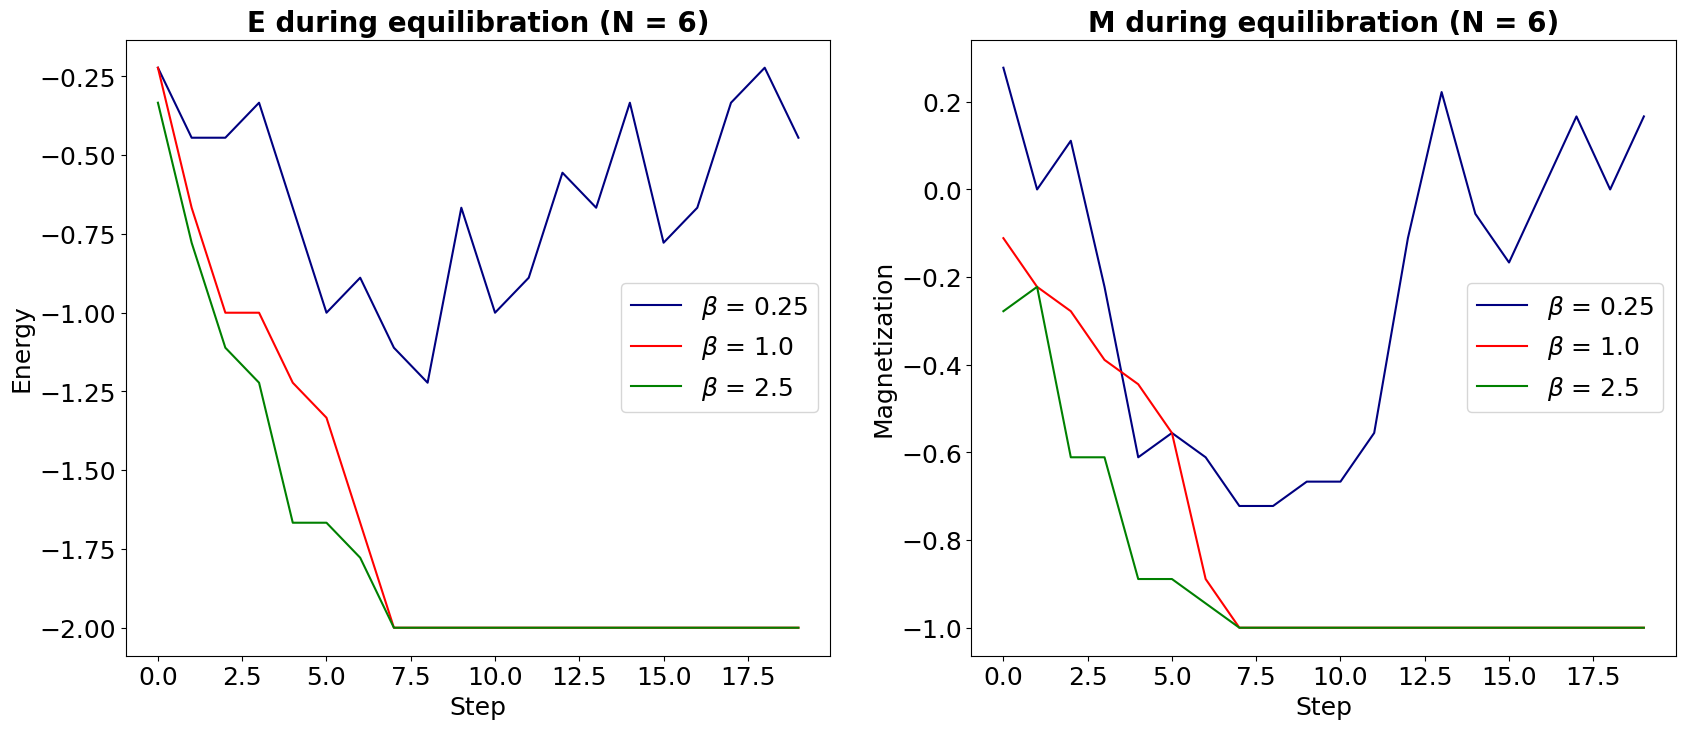

In [8]:
N_p = 6 #size of lattice
eq_steps = 20 #define number of equilibration steps
steps = 100 #define number of simulation steps
betas = np.array([0.25, 1, 2.5]) #values of beta to be used
col_map = np.array(["navy", "red", "green"])

#create plots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 8))
ax1.set_title(r"E during equilibration (N = {})".format(N_p), fontweight = "bold", fontsize = 20)
ax2.set_title(r"M during equilibration (N = {})".format(N_p), fontweight = "bold", fontsize = 20)
ax1.set_xlabel("Step", fontsize = 18)
ax2.set_xlabel("Step", fontsize = 18)
ax1.set_ylabel("Energy", fontsize = 18)
ax2.set_ylabel("Magnetization", fontsize = 18)
ax1.tick_params(axis="x",labelsize=18)
ax2.tick_params(axis="x",labelsize=18)
ax1.tick_params(axis="y",labelsize=18)
ax2.tick_params(axis="y",labelsize=18)

#loop over betas and compute values
for i in range(len(betas)):    
    E_mean, M_mean, E_var, M_var, E_eq, M_eq, E, M = Ising(N_p, betas[i], eq_steps, steps)
    
    ax1.plot(E_eq/N_p**2, label = r"$\beta$ = {}".format(betas[i]), c = col_map[i])
    ax2.plot(M_eq/N_p**2, label = r"$\beta$ = {}".format(betas[i]), c = col_map[i])
    
ax1.legend(fontsize = 18)
ax2.legend(fontsize = 18)
plt.show()

When beta = 0.25 the system is already in equilibrium from the beginning because $T_c< < T$. The system enters equilibrium faster when beta = 2.5 than when beta = 1. 

And in general the number of steps required to achieve thermodynamic equilibrium depends on the temperature and the size of the lattice. Generally, higher temperatures and smaller lattices reach equilibrium faster as we can see in this example.

Now we are going to graph **energy vs temperature** and **magnetization vs temperature** for different values of beta and lattice size.

In [9]:
N_T = 40
Ts = np.linspace(0.75, 3.75, endpoint=True, num=N_T)
betas = 1 / Ts

Ns = [10,20,30,40,50]
N_N = len(Ns)
eq_steps = int(1e4)
steps = int(1e4)

Es = np.zeros((N_N, N_T))
Ms = np.zeros((N_N, N_T))
E_error = np.zeros((N_N, N_T))
M_error = np.zeros((N_N, N_T))

for i,N in enumerate(Ns):
  print('Simulating N={}'.format(N))
  for j, beta in enumerate(tqdm(betas)):
    E_mean, M_mean, E_var, M_var, E_eq, M_eq, E, M = Ising(N, beta, eq_steps=eq_steps, steps=steps, 
                                                             annealing=False, cluster=False,verbose=False)

    Es[i,j] = E_mean
    Ms[i,j] = M_mean
    E_error[i,j] = E_var
    M_error[i,j] = M_var

Simulating N=10


  0%|          | 0/40 [00:00<?, ?it/s]

Simulating N=20


  0%|          | 0/40 [00:00<?, ?it/s]

Simulating N=30


  0%|          | 0/40 [00:00<?, ?it/s]

Simulating N=40


  0%|          | 0/40 [00:00<?, ?it/s]

Simulating N=50


  0%|          | 0/40 [00:00<?, ?it/s]

In [10]:
def plot_values(Es,Ms,E_error,M_error,N,startN=0,endN=Es.shape[0]-1):
    titles=['Energy','Magnetization']
    physical_quantities=[Es,np.abs(Ms)]
    Error = [E_error,M_error]
    plt.figure(figsize=(16,10))
    for i in range(len(physical_quantities)):
        ax=plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        ax.set_title(titles[i], fontsize = 20, fontweight = "bold" )
        ax.grid('--', alpha= 0.7)
        for j in range(startN,endN+1):
            #ax.plot(Ts[1:], physical_quantities[i][j][1:] / N[j]**2, '.',markersize=9, label='N='+str(N[j]), alpha=0.7)
            ax.errorbar(Ts[1:], physical_quantities[i][j][1:] / N[j]**2, yerr=Error[i][j][1:]/ N[j]**2,
                        linestyle='None', marker='.',markersize=9 , label='N='+str(N[j]), alpha=0.7)
                        
            ax.legend()
            
    plt.subplots_adjust(hspace=0.3)

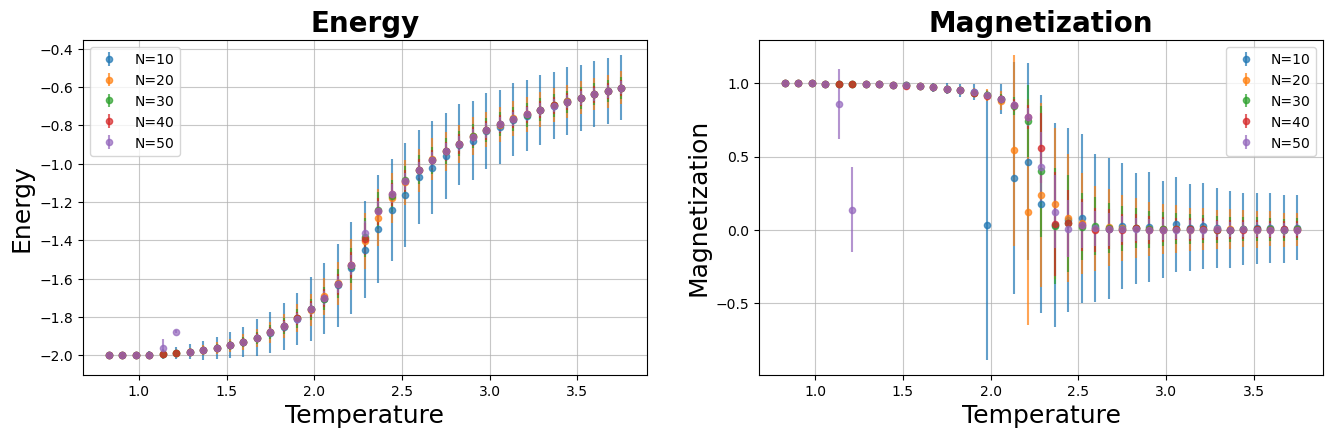

In [11]:
plot_values(Es,Ms,E_error,M_error,Ns,startN=0,endN=Es.shape[0]-1)

- As we can see in the figure above, when the system is small the error is high and even more so near the critical temperature, and as the system is larger the error decreases.

- The finite system size affects the behavior of the system (as we can see in the figures above for different beta and lattice zise), especially near critical points. For small lattice sizes, finite-size effects can dominate, leading to deviations from the behavior of an infinite system. Increasing the lattice size can help reduce finite-size effects.